Full disclosure: I went to a SIGAI meeting and we worked through & made this MNIST CNN.

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(320, 200)
        self.fc2 = nn.Linear(200, 10)
        
    def forward(self, x):
        # shape of x : (-1, 1, 28, 28)
        # shape is of format (batch_size, depth, height, width)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # shape of x after conv1: (-1, 10, 24, 24)
        # shape of x after max pool: (-1, 10, 12, 12)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # shape after dropout: (-1, 20, 8, 8)
        # shape after max pool: (-1. 20, 4, 4)
        x = x.view(-1, 320)
        # 20 * 4 * 4 = 320
        x = F.relu(self.fc1(x))
        # shape of x: (-1, 200)
        x = F.dropout(x, training=self.training)
        # shape of x: (-1, 200)
        x = self.fc2(x)
        # shape of x: (-1, 10)
        # (still 10 output for cifar10)
        return F.log_softmax(x, dim=1)

In [3]:
class Log_reg(nn.Module):
    def __init__(self):
        super(Log_reg, self).__init__()
        self.fc1 = nn.Linear(784, 10)
        
    def forward(self, x):
        # shape of x: (-1, 1, 28, 28)
        x = x.view(-1, 784)
        # (-1, 784)
        x = F.log_softmax(self.fc1(x))
        # (-1 10)
        return x

In [4]:
class two_layer_net(nn.Module):
    def __init__(self):
        super(two_layer_net, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 10)
        self.nonlinearity = F.relu
        
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.nonlinearity(self.fc1(x))
        x = F.log_softmax(self.fc2(x))
        return x

In [5]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # This loop iterates through the dataset
        data, target = data.to(device), target.to(device)
        # This moves data, target to gpu if you have one
        optimizer.zero_grad()
        # Delete previous gradients
        output = model(data)
        # Forward pass through the model
        # This cells model.forward(data)
        loss = F.nll_loss(output, target)
        # Negative log likelihood loss
        loss.backward()
        # Computes backward pass, computes gradients
        optimizer.step()
        # Performs gradient update
        if batch_idx % 6400 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

In [10]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [11]:
use_cuda = torch.cuda.is_available()
use_cuda = False
lr = 0.001
momentum = 0.5

epochs = 10
torch.manual_seed(2)
model_type="network"

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,), (0.3081,))
                  ])),
    batch_size=64, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
batch_size=64, shuffle=True, **kwargs)

if model_type == "network":
    model = Net().to(device)
elif model_type == "two_layer":
    model = two_layer_net().to(device)
else:
    model = Log_reg().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

if (model_type != "network"):
    thing = model.fc1

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320419

Test set: Average loss: 1.7522, Accuracy: 7290/10000 (73%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.764509

Test set: Average loss: 0.4845, Accuracy: 8695/10000 (87%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.665251

Test set: Average loss: 0.3304, Accuracy: 9089/10000 (91%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.448948

Test set: Average loss: 0.2656, Accuracy: 9234/10000 (92%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.388482

Test set: Average loss: 0.2223, Accuracy: 9349/10000 (93%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.427048

Test set: Average loss: 0.1945, Accuracy: 9430/10000 (94%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.190535

Test set: Average loss: 0.1735, Accuracy: 9478/10000 (95%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.151030

Test set: Average loss: 0.1566, Accuracy: 9525/10000 (95%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.241049

Test set: Average loss: 0.1441, Accuracy: 9580/10000 (96%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.320572


['__call__', '__class__', '__constants__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backend', '_backward_hooks', '_buffers', '_construct', '_forward_hooks', '_forward_pre_hooks', '_get_name', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_modules', '_named_members', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_tracing_name', '_version', 'add_module', 'apply', 'bias', 'buffers', 'children', 'cpu', 'cuda', 'double', 'dump_patches', 'eval', 'extra_repr', 'float', 'forward', 'half', 'in_features', 'load_state_dict', 'modules', 'named_buffers', 'named_chil

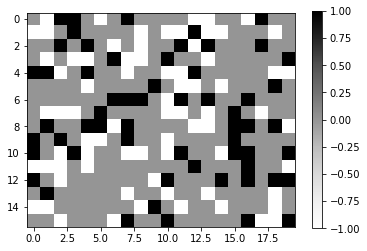

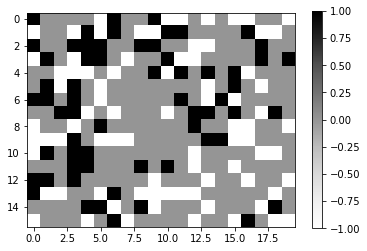

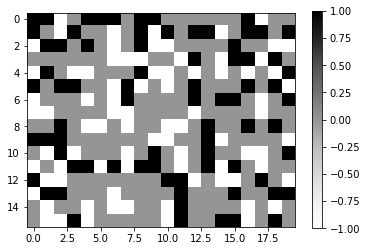

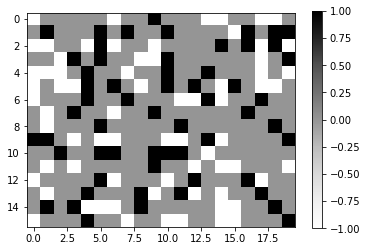

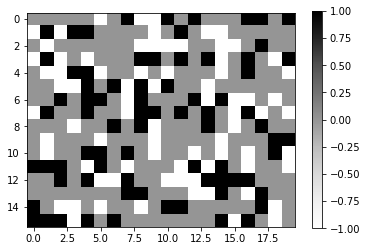

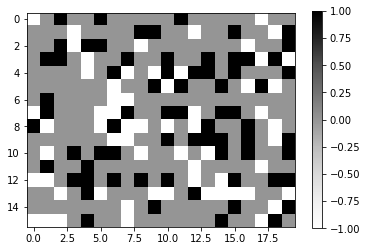

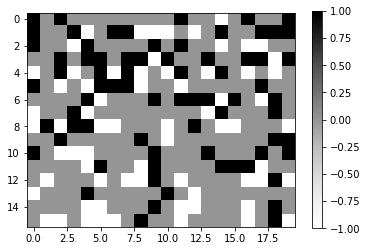

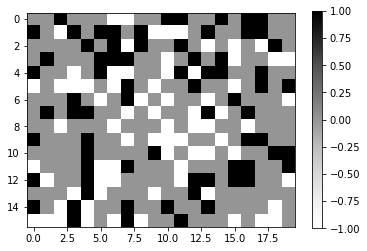

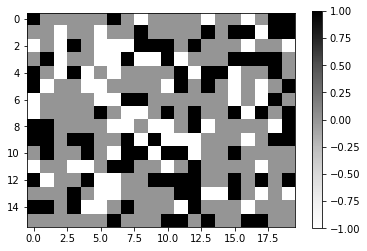

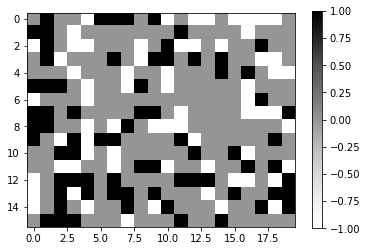

In [20]:
import numpy as np
print(dir(model.fc1))
w = model.fc1.weight
mats = []
for i in range(10):
    weights = w[i].reshape((16,20)).cpu().data.numpy()
    weights[np.greater(weights, 0.03)] = 1
    weights[np.less(weights, -0.03)] = -1
    weights[np.less(weights, 0.03) * np.greater(weights, -0.03)] = 0
    mats.append(weights)
    
import matplotlib
import matplotlib.pyplot as plt

for i in range(10):
    plt.figure()
    plt.imshow(mats[i], cmap='Greys')
    plt.colorbar()
    plt.show()